In [192]:
#Dependencies
import os
import numpy as np
import pandas as pd
import plotly
import datetime as dt
from fbprophet import Prophet
from fbprophet.diagnostics import performance_metrics
from fbprophet.diagnostics import cross_validation
from sklearn.model_selection import TimeSeriesSplit

In [2]:
os.getcwd()

'/Users/jacosta3/OneDrive - University of South Florida/Gerdau Projects/pft/scripts'

## Importing Structural 

In [3]:
#File directory
ser_path = "./serialized/"
#change directory to datasets
os.chdir("../datasets")

In [4]:
#read pickle file
structural = pd.read_pickle(ser_path + "structural_merged.pkl")

## Group by Block-level

In [5]:
structural = structural.groupby(['calendar_day','year','month', 'week','block']).sum()
structural = structural.reset_index()

In [6]:
structural.shape

(50323, 9)

## Train Test Split for Time Series

In [7]:
year_list = structural['year'].unique().tolist()
splits = {'train': [], 'test': []}

#note exception, we only have 3 series (2019 + 2020) should be aggregated because we only have a couple day-points in 2020
for idx, yr in enumerate(year_list[:-1]):
    train_yr = year_list[:idx+1]
    test_yr = [year_list[idx+1]]
    print('TRAIN: ', train_yr, 'TEST: ',test_yr)

    splits['train'].append(structural.loc[structural.year.isin(train_yr), :])
    splits['test'].append(structural.loc[structural.year.isin(test_yr), :])

TRAIN:  [2016] TEST:  [2017]
TRAIN:  [2016, 2017] TEST:  [2018]
TRAIN:  [2016, 2017, 2018] TEST:  [2019]
TRAIN:  [2016, 2017, 2018, 2019] TEST:  [2020]


In [8]:
splits['train'][0]

,calendar_day,year,month,week,block,IN_tons,SO_order_qty_sales_units,SH_shipment_tons,PR_ton
0,2016-01-02,2016,1,53,"5"" ANG",0.000000,39.0000,0.0,0.0
1,2016-01-02,2016,1,53,"5"" FLT",0.000000,3.0600,0.0,0.0
2,2016-01-03,2016,1,53,"1"" FLT",0.000000,10.0980,0.0,0.0
3,2016-01-03,2016,1,53,"1"" SB FLT",0.000000,22.5600,0.0,0.0
4,2016-01-03,2016,1,53,"1-2"" LRG FLT",0.000000,4.9385,0.0,0.0
...,...,...,...,...,...,...,...,...,...
11011,2016-12-31,2016,12,52,"9"" CHN",492.863993,0.0000,0.0,0.0
11012,2016-12-31,2016,12,52,"9"" FLT",10.876000,0.0000,0.0,0.0
11013,2016-12-31,2016,12,52,MC10X8.4,2.352000,0.0000,0.0,0.0
11014,2016-12-31,2016,12,52,MC12X10.6,8.480000,0.0000,0.0,0.0


## Prep Data for Prophet Ingestion

In [193]:
train = splits['train'][3]

### Picking one Block for analysis - 4" ANG

In [194]:
#in split 3(all years) there are at least 75 different blocks - ask greg if some of these are not common - can be discounted?
splits['train'][3]['block'].unique()

array(['5" ANG', '5" FLT', '1" FLT', '1" SB FLT', '1-2" LRG FLT',
       '10" CHN', '10" FLT', '12" CHN', '12" FLT', '15" CHN',
       '2 X 1" CHN', '2" ANG', '2-1/2" ANG', '3-1/2" ANG', '4 X 3" ANG',
       '4 X 3-1/2" ANG', '4" ANG', '5 X 3" ANG', '5 X 3-1/2" ANG',
       '5" CHN', '6 X 3-1/2" ANG', '6 X 4" ANG', '6" ANG', '6" CHN',
       '6" FLT', '7 X 4" ANG', '7" CHN', '7" FLT', '8 X 4" ANG',
       '8 X 6" ANG', '8" CHN', '8" FLT', '9" CHN', '9" FLT', 'MC10X8.4',
       'MC12X10.6', '1/2" SQR', '2" FLT', '2" MED FLT', '3-1/2" FLT',
       '4-1/2" FLT', '3" FLT', 'PR 1/4', 'PR 3/8', '4" FLT', '1-1/4" FLT',
       '3/4" SQR', '3/8" SQR', 'L2" FLT', '1" CHN', '8" ANG', '5/8" SQR',
       '1" SQR', '2" SQR', '3/4" FLT', '2" CHN', '1/4X3/4" FLT',
       '2-1/2" FLT', 'PR OTHERS', '1-1/4" SQR', '3 X 2" ANG', '3" CHN',
       'NS-1-1/4" FLT', '1-1/4" CHN', 'MC18" CHN', '2-1/2" CHN',
       'MC4" CHN', 'RANGE 5', '3/16X3/4" FLT', '1-1/2" CHN', '1-1/2 SQR',
       '9/16" RND', '1-1/2" FL

In [195]:
train = train[train['block']=='4" ANG']

In [196]:
train.shape

(1362, 9)

### Selecting & Changing Column Names

In [197]:
train = train[['calendar_day', 'SH_shipment_tons']]

In [198]:
#changing names for prophet consumption
train.columns = ['ds','y']
train.head()

,ds,y
16,2016-01-03,0.0
53,2016-01-04,13.0
85,2016-01-05,110.0
118,2016-01-06,44.0
150,2016-01-07,97.0


In [199]:
#train['y'].replace("-inf", 0)

### Resample to weeks

In [200]:
train = train.set_index('ds')

In [201]:
train = train.resample('W').sum().reset_index()

In [202]:
train.head()

,ds,y
0,2016-01-03,0.0
1,2016-01-10,297.0
2,2016-01-17,937.0
3,2016-01-24,392.0
4,2016-01-31,696.0


### Eliminate Weekends

In [203]:
#train_weekdays = train[train['ds'].dt.dayofweek < 5]

## Basic Model

In [214]:
# see documentation on prophet
#help(cross_validation)

In [207]:
prophet = Prophet(seasonality_mode="additive", yearly_seasonality=True,)
prophet.fit(train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [208]:
#creates future calendar with actual dates in training & future dates (determined)
future = prophet.make_future_dataframe(periods=52, freq='W')

In [209]:
#predict future
forecast = prophet.predict(future)

In [211]:
#plot last predictions
forecast[['ds','yhat_lower','yhat','yhat_upper']].tail()

,ds,yhat_lower,yhat,yhat_upper
257,2020-12-06,173.162322,534.620586,904.067383
258,2020-12-13,0.348314,381.615606,750.168656
259,2020-12-20,-159.413506,230.995004,579.909045
260,2020-12-27,-237.230956,119.237138,484.537050
261,2021-01-03,-259.975482,91.643004,454.281609


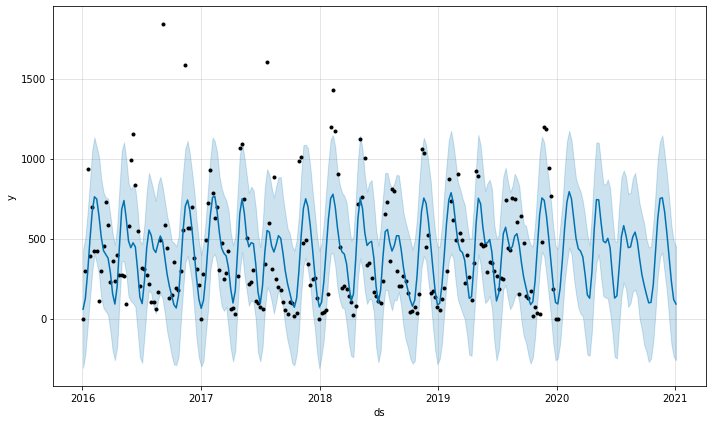

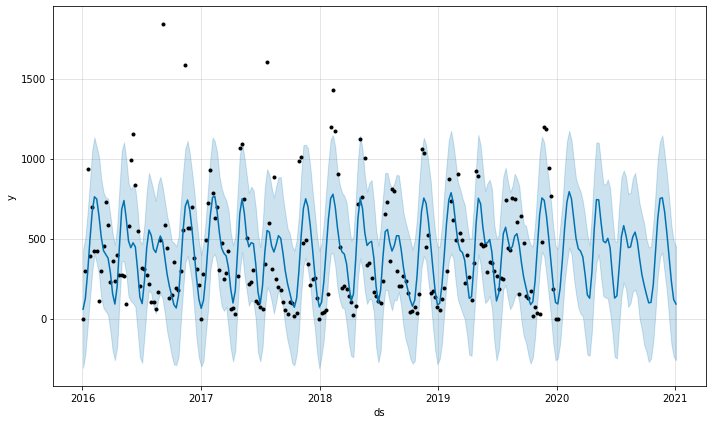

In [212]:
prophet.plot(forecast)

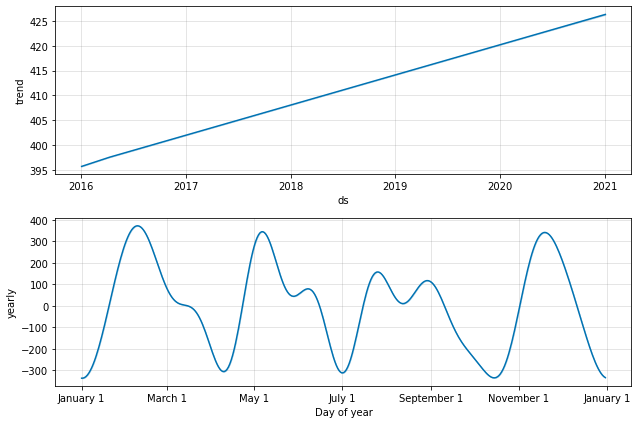

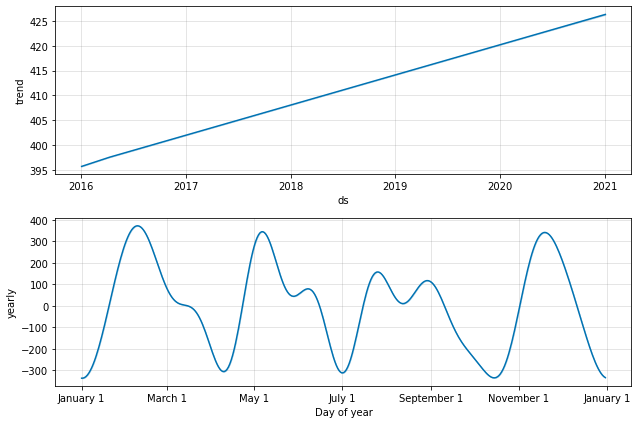

In [213]:
prophet.plot_components(forecast)

## Evaluating Model

In [215]:
help(cross_validation)

Help on function cross_validation in module fbprophet.diagnostics:

cross_validation(model, horizon, period=None, initial=None)
    Cross-Validation for time series.
    
    Computes forecasts from historical cutoff points. Beginning from
    (end - horizon), works backwards making cutoffs with a spacing of period
    until initial is reached.
    
    When period is equal to the time interval of the data, this is the
    technique described in https://robjhyndman.com/hyndsight/tscv/ .
    
    Parameters
    ----------
    model: Prophet class object. Fitted Prophet model
    horizon: string with pd.Timedelta compatible style, e.g., '5 days',
        '3 hours', '10 seconds'.
    period: string with pd.Timedelta compatible style. Simulated forecast will
        be done at every this period. If not provided, 0.5 * horizon is used.
    initial: string with pd.Timedelta compatible style. The first training
        period will begin here. If not provided, 3 * horizon is used.
    
    Ret

In [223]:
evaluate = cross_validation(prophet, initial="52 W", horizon="12 W", period="2 W")
%time

INFO:fbprophet:Making 73 forecasts with cutoffs between 2017-01-08 00:00:00 and 2019-10-13 00:00:00
CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.72 µs


In [226]:
evaluate.sample(20)

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
100,2017-06-04,1088.221698,823.265608,1380.970914,229.0,2017-04-30
404,2018-06-17,463.659897,37.693737,851.403469,164.0,2018-04-15
410,2018-05-20,449.315978,53.243859,814.594828,1002.0,2018-04-29
386,2018-04-22,309.038779,-58.528235,706.288962,76.0,2018-04-01
843,2019-10-13,54.857349,-308.105353,400.126886,174.0,2019-09-15
241,2017-10-29,353.044311,-4.144279,705.081284,983.0,2017-10-15
803,2019-10-13,32.306526,-298.180028,392.109707,174.0,2019-07-21
678,2019-04-21,226.240097,-132.530948,587.418872,350.0,2019-03-03
57,2017-05-14,385.647022,126.094264,652.490567,749.0,2017-03-05
475,2018-09-02,594.932083,185.305983,983.811723,203.0,2018-07-08


In [225]:
performance_metrics(evaluate)

INFO:fbprophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,coverage
0,14 days,127781.343673,357.465164,262.158717,0.551433,0.677374
1,21 days,140061.947071,374.248510,278.011051,0.701566,0.726500
2,28 days,147388.447992,383.912032,285.957558,0.630617,0.659266
3,35 days,142823.697468,377.920226,281.974926,0.684728,0.724295
4,42 days,148988.605254,385.990421,288.621911,0.657116,0.636278
5,49 days,144130.497705,379.645226,286.167061,0.675548,0.708392
6,56 days,140697.053960,375.096060,280.760362,0.571179,0.657062
7,63 days,140147.765416,374.363146,287.387031,0.667704,0.701307
8,70 days,134950.262459,367.355771,274.553657,0.549494,0.666352
9,77 days,133865.983425,365.877006,278.601869,0.661743,0.726500


In [ ]:
### Create standard function for measure of RMSE & MAE